<a href="https://colab.research.google.com/github/VAMDC/Jupyter_notebooks/blob/main/SpeciesDatabase/tutorial/SpeciesDB_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

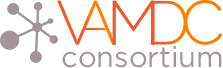

# Python interaction with the VAMDC species database

In this notebook we'll look at how to interact with the VAMDC infrastructure to retrieve atomic and chemical information.

To to this, let us define the different REST-API endpoints:




---


- **metadata** - [https://species.vamdc.org/web-service/api/v12.07/metadata](https://species.vamdc.org/web-service/api/v12.07/metadata), which resolves to a Json object containing some statistics: the number of active *data-nodes* (i.e. the number of VAMDC federated databases that have been tagged as valid during the curation phase), the date of the most recent execution of the ingestion script, the total number of unique species indexed in the Species Database.
    ```json
    {
     "nodesCount": "33",
     "lastUpdate": "2023-11-20",
     "speciesCount": "2770"
    }
    ```
    

---






---


- **nodes** - [https://species.vamdc.org/web-service/api/v12.07/nodes](https://species.vamdc.org/web-service/api/v12.07/nodes), which resolves to a JSON list containing the *data-node* information stored in the Species Database. An example of the structure of the output produced by this service is provided in the following listing, which displays information for the Basecol *data-node*: *shortName* is the human-readable name of the *data-node*, *description* is its concise description, *contactEmail* is the e-mail of its technical maintainer, *ivoIdentifier* is its IVOID (cf. Table 1), *referenceUrl* is the link to the official database website, and *lastUpdate* is the date of the most recent execution of the ingestion script, which updates the information and builds the list of *topics*. We recall that the information for this example is extracted from the Basecol Registry entry during the ingestion phase.
    ```json
   [
    {
        "shortName": "BASECOL2015: VAMDC-TAP interface",
        "description": "",
        "contactEmail": "yaye-awa.ba[at]obspm[dot]fr",
        "ivoIdentifier": "ivo://vamdc/basecol2015/vamdc-tap",
        "referenceUrl": "https://basecol.vamdc.org/",
        "lastUpdate": "2023-11-20 03:00:10",
        "topics": [
            "Atomic states",
            "Atoms",
            "Collisions",
            "Molecular states",
            "Molecules"
        ]
    },
    ...
   ]
  

---





---



- **species** - [https://species.vamdc.org/web-service/api/v12.07/species](https://species.vamdc.org/web-service/api/v12.07/species), which resolves to a Json list containing all the species gathered from all the federated databases. The following listing  gives an example of the structure of the produced output, obtained while hitting this endpoint:

    - each text strings starting with *ivo* is a *data-node* unique identifier. We naturally use the same node-identifiers defined into the VAMDC registry.
    - The value associated with each *data-node* identifier is the list of the chemical species for which there is (or there have been) data available in the *data-node*.
    - The description of each chemical species consists of its InchI/InChIKey, its stoichiometric formula and formula (this last field is null for atoms and consists of a string notation that shows the isotopes and number of atoms in a molecule), mass number, species type (this field may take one of the three *atom, molecule, particle* values), electric charge, species name (in natural language). The two dates associated with the field *lastSeenDateTime* are respectively the last time the ingestion script has been executed and the last time the species was available in the *data-node*. Indeed, some data may be deleted/changed inside *data-nodes* and, as a consequence, some chemical species may no longer be available. The Species Database keeps track of the availability of all the species over time.


```json
 "ivo://vamdc/amdis-ionization": [
        {
            "InChI": "InChI=1S/H/q-1",
            "InChIKey": "KLGZELKXQMTEMM-UHFFFAOYSA-N",
            "stoichiometricFormula": "H",
            "massNumber": 1,
            "charge": -1,
            "speciesType": "atom",
            "formula": "None",
            "name": "Hydrogen negative ion -1",
            "did": "KLGZELKXQMTEMM-UHFFFAOYSA-N",
            "lastSeenDateTime": "2023-11-20 $\mid \mid$ 2023-11-20"
        },  
        {
            ...
        }
    ],
    "ivo://vamdc/sesam/tap-xsams": [
        {
            "InChI": "InChI=1S/H2/h1H",
            "InChIKey": "UFHFLCQGNIYNRP-UHFFFAOYSA-N",
            "stoichiometricFormula": "H2",
            "massNumber": 2,
            "charge": 0,
            "speciesType": "molecule",
            "formula": "H2",
            "name": "Dihydrogen\n",
            "did": "UFHFLCQGNIYNRP-UHFFFAOYSA-N",
            "lastSeenDateTime": "2023-11-20 $\mid \mid$ 2023-11-20"
        },
        {
            ...
        }
    ]    
    }
```

The **species** endpoint may take some additional parameters to refine the

search and filter the results. The following table describes those searching parameters, along with the operation they induce on the behavior of the API. The refined API-call may be composed as follows:

[https://species.vamdc.org/web-service/api/v12.07/species?P_1=V_1&P_2=V_2&...&P_N=V_N](https://species.vamdc.org/web-service/api/v12.07/species?P_1=V_1&P_2=V_2&...&P_N=V_N) , where:

- $N \in [0,11]$. The value $0$ means that no optional parameter is provided. The value $11$ is the number of rows of [SpeciesParams]the following table and $N=11$ means that all the optional parameters are provided.
- $P_i$, $i \in [1,N]$ for $N \ge 1$, is the parameter at the $i^{th}$ row of the following table.
- $V_i$ is the value taken by $P_i$. It must satisfy the constraint expressed in the second column of the following table at row $i$.

| Parameter              | Authorized type/values                | API functionality                                                                                                      |
|------------------------|---------------------------------------|------------------------------------------------------------------------------------------------------------------------|
| stoichiometric_formula | String                                | Restriction to the results where the stoichiometric formula is equal to the user provided value                        |
| mass_min               | Positive Integer                      | Restriction to the results having $massNumber \geq mass\_min$ {$^\dagger$}                                               |
| mass_max               | Positive Integer                      | Restriction to the results having $massNumber \leq mass\_max$ {$^\dagger$}                                               |
| charge_min             | Integer                               | Restriction to the results having $charge \geq charge\_min$ {$^\star$}                                                   |
| charge_max             | Integer                               | Restriction to the results having $charge \leq charge\_max$ {$^\star$}                                                   |
| type                   | String $\in \mathcal S :=\{$ "atom", "molecule", "particle" $\}$ | Restriction the results where the {\it type} is equal to the user provided value. If the provided string $s \notin \mathcal S$, a JSON object describing the error is returned |
| ivo_identifier         | String                                | Restriction to the results having the {\it data-node} identifier (IVOID) equal to the user provided value              |
| inchikey               | String                                | Restriction to the results where having the {\it InChIKey} equal to the user provided value                            |
| name                   | String                                | Restriction to the results where having the {\it name} equal to the user provided value                                 |
| formula                | String                                | Restriction to the results where having the {\it formula} equal to the user provided value                              |
| text_search            | String                                | Restriction to the results having at least a portion of one of the five fields {\it stoichiometric_formula, formula, name, InChi, inchikey} equal to the user provided value |

Details of the optional parameters for the Species endpoint

{$\dagger$} If both *mass_min* and *it mass_max* are provided, the difference (*mass_max*-*mass_min*) is checked to be positive. An error message is returned if the difference is negative.

{$\star$} If both *charge_min* and *charge_max* are provided, the difference (*charge_max*-*charge_min*) is checked to be positive. An error message is returned if the difference is negative.



---





---


- **merged_fields_vals** - [https://species.vamdc.org/web-service/api/v12.07/species/merged_fields_vals](https://species.vamdc.org/web-service/api/v12.07/species/merged_fields_vals), which resolves to a Json list that is the concatenation, for all the indexed species, of the fields *stoichiometricFormula, formula, name, InChi, InChiKey*.


- **excelDump** - [https://species.vamdc.org/web-service/api/v12.07/excelDump](https://species.vamdc.org/web-service/api/v12.07/excelDump) which resolves to a timestamped Excel file containing a dump of all the data from the Species Database. This file is composed of two tabs, one for the *data-nodes* and the other for the species.


---





---



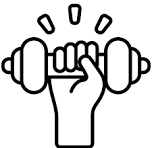
# Travaux pratiques



1.   Let's have some information on the nodes:

  a. Is Nicolas in charge of any node? If yes, which one(s)?

  b. Is Carlo in charge of any node? If yes, which one(s)?  


2.   Let us search for some chemical species (ex. *Carbon Monoxide* - but you can choose your favourite chemical species)

  a. What are the unique identifiers (InChi/InChiKey) associated with this species? (there may be several ones)

  b. In which database could you find data associated with this species? (use the InChi/InChiKey in your query)


3.   Get some spectrpscopic (or rhovibrational) data from the VAMDC infrastructure about the species you have chosen (some good inspiration at https://github.com/cmzwolf/JupyterVAMDCPortal/blob/main/portalTest.ipynb)
